In [55]:
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Convolutional Layers
## Implementing Convolutional Layers With Keras

In [56]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

In [57]:
images.shape

TensorShape([2, 70, 120, 3])

In [58]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [59]:
fmaps.shape

TensorShape([2, 64, 114, 32])

In [60]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding='same')
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

In [61]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [62]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides      # (i_h – f_h + s ) / s
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1   # i_h / s_h , rounded up
        num_padded = (output_size - 1) * strides + kernel_size - input_size     # (o_w – 1) × s_h + f_h - i_h
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [63]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [64]:
biases.shape

(32,)

In [65]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

# Pooling Layers
## Implementing Pooling Layers With Keras
**Max pooling**

In [66]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
output = max_pool(images)

In [67]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        print(new_shape)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

tf.Tensor([  2  70 120   1   3], shape=(5,), dtype=int32)


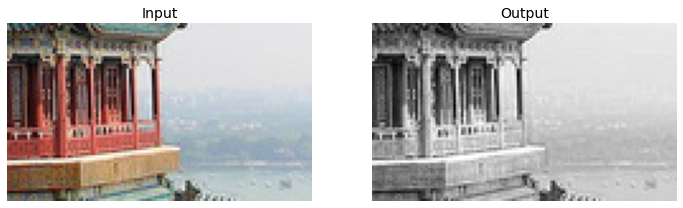

In [68]:
# # extra code – shows that this custom layer gives the same result as max_pool()
# np.allclose(DepthPool(pool_size=3)(fmaps), output)
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling**  
Compute the mean of each entire feature map (it’s like an
average pooling layer using a pooling kernel with the same spatial
dimensions as the inputs).

In [69]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
# global_avg_pool = tf.keras.layers.Lambda(
#     lambda X: tf.reduce_mean(X, axis=[1, 2]))
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.2601088 , 0.10848834]], dtype=float32)>

# CNN Architectures
**Tackling Fashion MNIST With a CNN**  
A common mistake is to use convolution kernels that are too large. For example, instead
of using a convolutional layer with a 5 × 5 kernel, stack two layers with 3 × 3 kernels: it
will use fewer parameters and require fewer computations, and it will usually perform
better

In [70]:
a = np.array([3,2])
print(a.shape)    # (2,)
a = np.expand_dims(a, axis=-1)
print(a.shape)    # (2, 1)

mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
print(X_train_full.shape, y_train_full.shape)
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
print(X_train_full.shape, y_train_full.shape)
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


(2,)
(2, 1)
(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (60000,)


In [71]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D,  kernel_size=3, padding='same', activation='swish', kernel_initializer='he_normal')

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128 , activation='swish', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(units=64 , activation='swish', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(units=10 , activation='softmax')
])

In [72]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5585 - accuracy: 0.8115 - val_loss: 0.3448 - val_accuracy: 0.8736
Epoch 2/10
1719/1719 [==============================] - 28s 17ms/step - loss: 1.3521 - accuracy: 0.7727 - val_loss: 0.5206 - val_accuracy: 0.8102
Epoch 3/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.5079 - accuracy: 0.8198 - val_loss: 0.3664 - val_accuracy: 0.8642
Epoch 4/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.4075 - accuracy: 0.8600 - val_loss: 0.3485 - val_accuracy: 0.8666
Epoch 5/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3674 - accuracy: 0.8735 - val_loss: 0.3128 - val_accuracy: 0.8834
Epoch 6/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3391 - accuracy: 0.8821 - val_loss: 0.2976 - val_accuracy: 0.8908
Epoch 7/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3169 - accuracy: 0.8906 - val_loss: 0.2852 -